# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os

plt.rcParams["figure.figsize"] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5

In [2]:
DATA_DIR = 'data'
plots_dir = 'plots'

# Loading Data

We will start by loading the data. We will use `scipy` to load the data. Then we will use `torch` to batch the dataset.

In [3]:
data = loadmat(os.path.join(DATA_DIR, 'burgers_data_R10.mat'))
data["a"].shape, data["u"].shape

((2048, 8192), (2048, 8192))

The original dataset has a shape of `(2048, 8192)`. We will subsample the dataset with factor of 8 on the second dimension to make it in a shape `(2048, 1024)`:

In [4]:
subsmaple = 2**3 
h = 2**13 // subsmaple

x_data = data['a'][:,::subsmaple]
y_data = data['u'][:,::subsmaple]
x_data= x_data.astype(np.float32)
x_data= torch.from_numpy(x_data)
y_data= y_data.astype(np.float32)
y_data= torch.from_numpy(y_data)

x_data.shape, y_data.shape

(torch.Size([2048, 1024]), torch.Size([2048, 1024]))

There are 2048 samples in the dataset. However, we will only use first 1000 samples for training and the last 100 samples for testing:

In [5]:
train_samples = 1000
test_smaples = 100
x_train = x_data[:train_samples,:]
y_train = y_data[:train_samples,:]
x_test = x_data[-test_smaples:,:]
y_test = y_data[-test_smaples:,:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([1000, 1024]),
 torch.Size([1000, 1024]),
 torch.Size([100, 1024]),
 torch.Size([100, 1024]))

Finally, we will reshape the datasetnd create a batch dataloader:

In [6]:
batch_size = 20

x_train = x_train.reshape(train_samples,h,1)
x_test = x_test.reshape(test_smaples,h,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

Great! Now we have data ready to go!

# The Model

## The Fourier Block

We will first create a class for one dimensional Fourier block as given in the PDF. Here is a class which implements this:

In [7]:
class SpectralConv1d(nn.Module):
    """The SpectralConv1d class implements a 1D Fourier layer. Does FFT, linear transform and then does inverse FFT to\\
        return values in real space."""

    def __init__(self, in_channels, out_channels, modes):
        """ 1D Fourier layer. Does FFT, linear transform and then does inverse FFT to\\ 
        return values in real space.

        Parameters
        ----------
        in_channels : int
            Number of input channels.
        out_channels : int
            Number of output channels.
        modes : int
            Number of Fourier modes to use, at most floor(N/2) + 1 where N is the\\
            number of points in the signal.
        """
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale
            * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat)
        )

    def complex_multiplication(self, input, weights):
        """Does complex multiplication of two tensors for the linear transformation.

        Parameters
        ----------
        input : torch.Tensor
            Input tensor of shape (batchsize, in_channels, input_size)
        weights : torch.Tensor
            Weights tensor of shape (in_channels, out_channels, modes)

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batchsize, out_channels, input_size)
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        """The forward pass of the layer.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batchsize, in_channels, input_size)

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batchsize, out_channels, input_size)
        """
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        output_c_channels = x.size(-1) // 2 + 1
        if self.modes > output_c_channels:
            raise ValueError(
                f"Number of output modes must not be greater than the maximum frequencies in input.\
                             \\Max frequency {output_c_channels} < {self.modes} modes to choose."
            )
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            output_c_channels,
            device=x.device,
            dtype=torch.cfloat,
        )
        out_ft[:, :, : self.modes] = self.complex_multiplication(
            x_ft[:, :, : self.modes], self.weights
        )

        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

## The FNO Model

Next, we create the model. The network consists of 4 spectral convolution layers defined above, each followed by a linear layer and a `GELU` activation function. The final layer is a linear layer with a single output.

In [8]:
class FNO1D(nn.Module):
    """FNO network in 1D
    The network consists of 4 spectral convolution layers, each followed by a linear layer and a GELU activation\\
        function. The final layer is a linear layer with a single output.
    """

    def __init__(self, modes, width):
        """Initializes the FNO1D Class

        The network consists of 4 spectral convolution layers, each followed by a linear layer and a GELU activation\\
        function. The final layer is a linear layer with a single output.
        
        Parameters
        ----------
        modes : int
            Number of Fourier modes to use, at most floor(N/2) + 1 where N is the\\
            number of points in the signal.
        width : int
            Width of the network.
        """
        super(FNO1D, self).__init__()
        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(2, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        """Does a forward pass of the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batchsize, input_size, 2)

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batchsize, input_size, 1)
        """
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        """Creates a grid of points in real space.

        Parameters
        ----------
        shape : tuple
            Shape of the input tensor.
        device : torch.device
            Device to use for the grid.

        Returns
        -------
        torch.Tensor
            Grid tensor of shape (batchsize, input_size, 1)
        """
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

## The LP Loss and Training the Model

Finally, we define the `LpLoss` object which will be used for optimization:

In [9]:
class LpLoss:
    """The Lp loss function."""
    def __init__(self, p=2):
        """Instantiates the LpLoss class.
        
        Parameters
        ----------
        p : int, optional
            The p in Lp norm. Defaults to 2.
        
        Raises
        ------
        ValueError
            If p < 1.
        """
        if p<1:
            raise ValueError(f"p must be greater than 1. Recieved {p}")
        self.p = p

    def call(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x - y, dim=1, p=self.p)
        y_norms = torch.norm(y, dim=1, p=self.p)

        return torch.sum(diff_norms/y_norms)/num_examples

    def __call__(self, x, y):
        return self.call(x, y)

Let's see how the FNO architecture looks like. We will also calculate the number of parameters in the model:

In [10]:
def multiply(*args):
    m = 1
    for i in args:
        m*=i
    return m

def count_params(model):
    parameters = 0
    for p in model.parameters():
        if p.is_complex():
            parameters += 2*multiply(*list(p.size()))
        else:
            parameters+=multiply(*list(p.size()))
    return parameters

modes = 16
width = 64
model = FNO1D(modes, width)
print(model)
print("Total Number of Parameters: ", count_params(model))

FNO1D(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Total Number of Parameters:  549569


In [11]:
epochs = 50
learning_rate = 0.001
step_size = train_samples//batch_size
gamma = 0.97

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
train_mse_losses=[]
train_l2_losses=[]
test_mse_losses=[]
test_l2_losses=[]

for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    j = 0
    for x, y in train_loader:
        j+=1
        optimizer.zero_grad()
        out = model(x)
        
        y = torch.unsqueeze(y, -1)
        mse = torch.mean((y-out)**2)
        l2 =  LpLoss(2)(y, out)
        l2.backward()

        optimizer.step()
        scheduler.step()
        for param_group in optimizer.param_groups:
            new_lr = param_group['lr']
            if new_lr != learning_rate:
                learning_rate = new_lr
                print("Changing Learning rate to: {}...".format(param_group['lr']))
        train_mse += mse.item()
        train_l2 += l2.item()
        print(f"At Batch {j:>3d}/{step_size}: MSE Loss {(train_mse/j):.6f} || L2 Loss {(train_l2/j):.6f}", end="\r")
    model.eval()
    test_l2 = 0.0
    test_mse = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            y = torch.unsqueeze(y, -1)
            out = model(x)
            test_mse += torch.mean((y-out)**2).item()
            test_l2 +=  LpLoss(2)(y, out).item()

    train_mse /= len(train_loader)
    train_l2/=len(train_loader)
    test_l2 /= len(test_loader)
    test_mse /=len(test_loader)
    train_l2_losses.append(train_l2)
    train_mse_losses.append(train_mse)
    test_l2_losses.append(test_l2)
    test_mse_losses.append(test_mse)

    print(f"Epoch {ep+1:>3d}/{epochs} || Train MSE {train_mse:6f} || Train L2 {train_l2:6f} || Test MSE {test_mse:6f} || Test L2 {test_l2:6f}")

Changing Learning rate to: 0.0009699999999999999...3918
Epoch   1/50 || Train MSE 26.675634 || Train L2 1.169040 || Test MSE 18.085400 || Test L2 0.915313
Changing Learning rate to: 0.0009408999999999999...4972
Epoch   2/50 || Train MSE 1.546068 || Train L2 0.317364 || Test MSE 0.001131 || Test L2 0.060289
Changing Learning rate to: 0.0009126729999999999...756
Epoch   3/50 || Train MSE 0.000852 || Train L2 0.052458 || Test MSE 0.000490 || Test L2 0.029504
Changing Learning rate to: 0.0008852928099999999...169
Epoch   4/50 || Train MSE 0.000324 || Train L2 0.031170 || Test MSE 0.000350 || Test L2 0.034650
Changing Learning rate to: 0.0008587340256999998...613
Epoch   5/50 || Train MSE 0.000223 || Train L2 0.026663 || Test MSE 0.000186 || Test L2 0.026360
Changing Learning rate to: 0.0008329720049289999...405
Epoch   6/50 || Train MSE 0.000169 || Train L2 0.025349 || Test MSE 0.000237 || Test L2 0.027411
Changing Learning rate to: 0.0008079828447811299...578
Epoch   7/50 || Train MSE 0.0

In [12]:
torch.save(model.state_dict(), 'fno.pt')

## Plotting the Losses

Let's plot the losses:

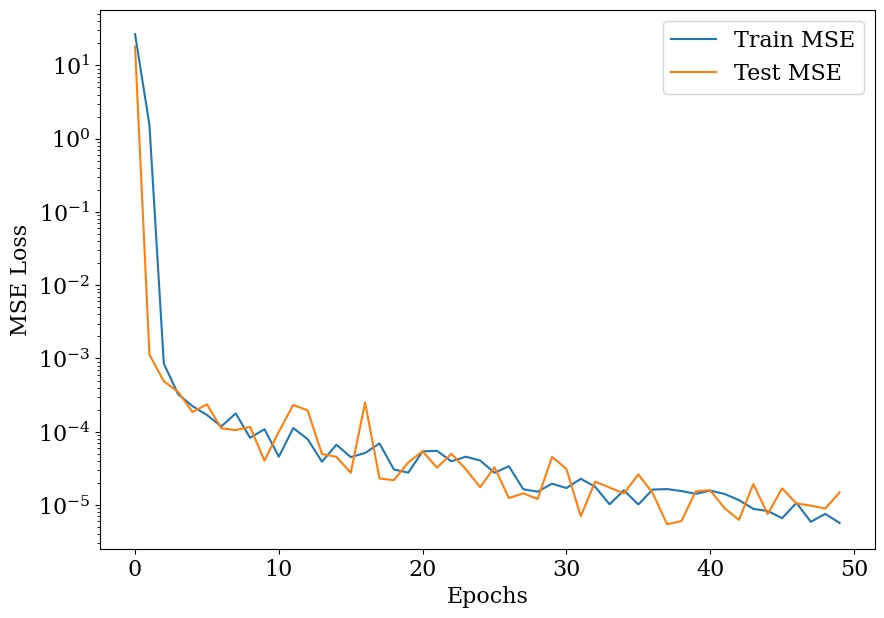

In [13]:
plt.plot(train_mse_losses, label="Train MSE")
plt.plot(test_mse_losses, label="Test MSE")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.savefig(os.path.join("plots", "0101.png"))
plt.show()

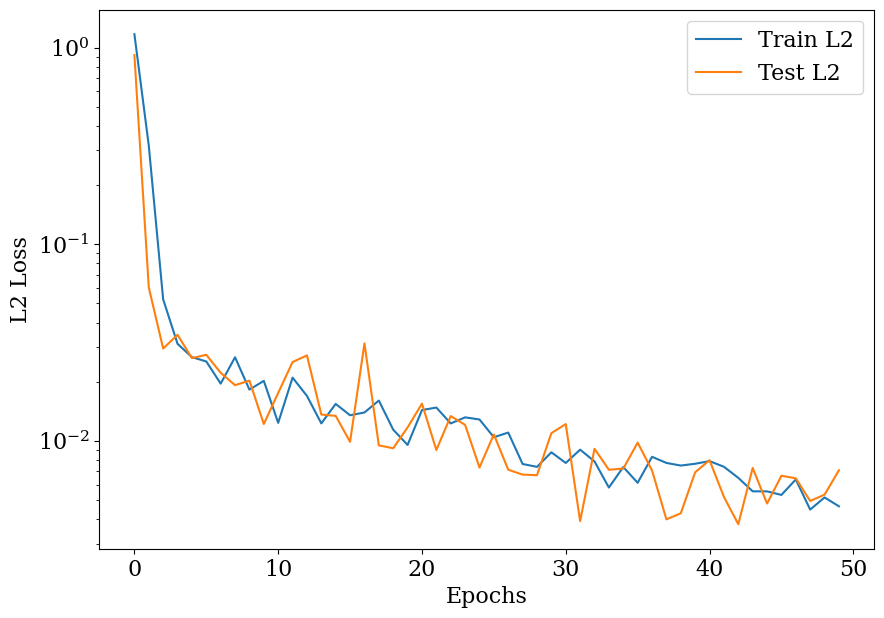

In [14]:
plt.plot(train_l2_losses, label="Train L2")
plt.plot(test_l2_losses, label="Test L2")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("L2 Loss")
plt.yscale("log")
plt.savefig(os.path.join("plots", "0102.png"))